In [527]:
# Copyright (c) 2023-2024 Pietro Luca Mazzacuva <pietroluca.mazzacuva@unicampus.it>
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import gzip, os, subprocess, shlex, time
from tqdm import tqdm
import pandas as pd

def return_G(x):
    return eval(x)[2]
def return_C(x):
    return eval(x)[1]
def return_coverage(x):
    return sum(eval(x))

samples = [
             ["884892094", "/lustre/home/pietrolucamazzacuva/U87/sra/SRR388226_SRR388227/DnaRna_884892094"],
             ["431083763", "/lustre/home/pietrolucamazzacuva/U87/sra/SRR388228_SRR388229/DnaRna_431083763"],    
          ]

save_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"

wt = []
ko = []
for sampleID, path in samples:
    for table in os.listdir(path):
        if table.find("parameters") == -1:
            print(table)

            p = subprocess.Popen(["grep", "-c", "$", os.path.join(path, table)], 
                                 stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            result, err = p.communicate()
            number_of_lines = int(str(result.strip().split()[0]).replace("'", " ")[2:])

            with open(os.path.join(path, table), "r") as redi:
                with tqdm(total=number_of_lines, desc=f"Counting A to G in {table} table", leave=True) as pbar:
                    for row in redi:
                        line = row.split("\t")
                        try:
                            if line[0].find("chr") != -1 and line[0] != "chrM":
                                if line[2] == "A" or line[2] == "T":
                                    if sampleID == "884892094": 
                                        if line[7] == "AG" or  line[7] == "TC":
                                            rcov = return_coverage(line[6])
                                            if rcov >= 30: 
                                                if line[2] == "A":
                                                    nsub = return_G(line[6])
                                                else:
                                                    nsub = return_C(line[6])
                                                if nsub >= 2:
                                                    if nsub/rcov >= 0.01:
                                                        wt.append(line)
                                    else:
                                        rcov = return_coverage(line[6])
                                        if rcov >= 30: 
                                            if line[7] == "AG" or  line[7] == "TC":
                                                if line[2] == "A":
                                                    nsub = return_G(line[6])
                                                else:
                                                    nsub = return_C(line[6])
                                                if nsub >= 2:
                                                    if nsub/rcov >= 0.01:
                                                        ko.append(line+["SUB"])
                                            else:
                                                if line[7] == "-":
                                                    ko.append(line+["NO-SUB"])
                        except:
                            continue
                        pbar.update(1)
                    
wt = pd.DataFrame(wt, columns=[f"{i}" for i in range(14)])
print(wt)
ko = pd.DataFrame(ko, columns=[f"{i}" for i in range(15)])
print(ko)


outTable_884892094


Counting A to G in outTable_884892094 table: 100%|██████████| 252593820/252593820 [05:04<00:00, 830331.51it/s]


outTable_431083763


Counting A to G in outTable_431083763 table: 100%|██████████| 241607877/241607877 [19:34<00:00, 205766.61it/s] 


          0          1  2  3    4      5               6   7     8  9 10 11  \
0      chrY   21152665  A  2   88  38.32   [84, 0, 4, 0]  AG  0.05  -  -  -   
1      chrY   21152719  T  2   74  38.07   [0, 74, 0, 0]  TC  1.00  -  -  -   
2      chrY   21152967  A  1   47  37.47   [0, 0, 47, 0]  AG  1.00  -  -  -   
3      chrY   21153275  A  2   44  38.20   [0, 0, 44, 0]  AG  1.00  -  -  -   
4      chrY   21153459  A  2   43  40.60   [0, 0, 43, 0]  AG  1.00  -  -  -   
...     ...        ... .. ..  ...    ...             ...  ..   ... .. .. ..   
25860  chr8  146075670  A  2   43  38.26   [41, 0, 2, 0]  AG  0.05  -  -  -   
25861  chr8  146076021  A  2  104  42.08  [101, 0, 3, 0]  AG  0.03  -  -  -   
25862  chr8  146076083  A  2   88  39.88   [86, 0, 2, 0]  AG  0.02  -  -  -   
25863  chr8  146076504  T  2   84  36.58   [0, 2, 0, 82]  TC  0.02  -  -  -   
25864  chr8  146281185  T  2   91  38.32   [0, 2, 0, 89]  TC  0.02  -  -  -   

      12   13  
0      -  -\n  
1      -  -\n  
2  

In [528]:
ko_sub = ko[ko.loc[:, "14"]=="SUB"].loc[:, ["0", "1"]]
ko_no_sub = ko[ko.loc[:, "14"]=="NO-SUB"].loc[:, ["0", "1"]]
wt_sub = wt.loc[:, ["0", "1"]]


positives = wt_sub.merge(ko_no_sub, how ="inner", on=["0", "1"])
negatives = wt_sub.merge(ko_sub, how ="inner", on=["0", "1"])


print(len(positives))
print(len(negatives))

11348
5051


In [529]:
positives.columns = ["Region", "Position"]
positives.loc[:, "Class"] = 1
positives.to_csv(os.path.join(save_path, "candidates_positives_first_filtering.tsv"), sep="\t", index=None)

negatives.columns = ["Region", "Position"]
negatives.loc[:, "Class"] = 0
negatives.to_csv(os.path.join(save_path, "candidates_negatives_first_filtering.tsv"), sep="\t", index=None)

In [ ]:
import gzip, os, subprocess, shlex, time
from tqdm import tqdm
import pandas as pd

def return_G(x):
    return eval(x)[2]
def return_C(x):
    return eval(x)[1]
def return_coverage(x):
    return sum(eval(x))

samples = [
             ["519021174", "/lustre/home/pietrolucamazzacuva/U87/sra/SRR8670718/DnaRna_519021174"]    
          ]

save_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"

wgs = []

for sampleID, path in samples:
    for table in os.listdir(path):
        if table.find("parameters") == -1:
            print(table)

            p = subprocess.Popen(["grep", "-c", "$", os.path.join(path, table)], 
                                 stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            result, err = p.communicate()
            number_of_lines = int(str(result.strip().split()[0]).replace("'", " ")[2:])

            with open(os.path.join(path, table), "r") as redi:
                with tqdm(total=number_of_lines, desc=f"Counting A to G in {table} table", leave=True) as pbar:
                    for row in redi:
                        line = row.split("\t")
                        try:
                            if line[0].find("chr") != -1 and line[0] != "chrM":
                                if line[2] == "A" or line[2] == "T":
                                        if line[7] == "AG" or  line[7] == "TC":
                                            rcov = return_coverage(line[6])
                                            if rcov >= 10: 
                                                wgs.append(line)
                                    
                        except:
                            continue
                        pbar.update(1)
                    
wgs = pd.DataFrame(wgs, columns=[f"{i}" for i in range(14)])
print(wgs)


In [2]:
wgs = pd.DataFrame(wgs, columns=[f"{i}" for i in range(14)])
print(wgs)
wgs = wgs.loc[:, ["0", "1"]]
wgs.columns = ["Region", "Position"]
wgs.to_csv(os.path.join(save_path, "wgs_snps.tsv"), sep="\t", index=None)


            0          1  2  3   4      5              6   7     8  9 10 11  \
0        chrY    3712461  T  0  13  44.69  [0, 12, 0, 1]  TC  0.92  -  -  -   
1        chrY    3712546  T  2  17  41.47  [0, 16, 0, 1]  TC  0.94  -  -  -   
2        chrY    3713095  A  2  19  38.05  [0, 0, 19, 0]  AG  1.00  -  -  -   
3        chrY    3713541  A  2  21  41.29  [20, 0, 1, 0]  AG  0.05  -  -  -   
4        chrY    3713954  A  0  10  40.60   [2, 0, 8, 0]  AG  0.80  -  -  -   
...       ...        ... .. ..  ..    ...            ...  ..   ... .. .. ..   
3873434  chr9  141109732  A  2  11  38.82  [10, 0, 1, 0]  AG  0.09  -  -  -   
3873435  chr9  141111136  A  0  12  39.75  [11, 0, 1, 0]  AG  0.08  -  -  -   
3873436  chr9  141111948  A  2  11  35.91  [10, 0, 1, 0]  AG  0.09  -  -  -   
3873437  chr9  141127489  T  2  21  41.05  [0, 5, 0, 16]  TC  0.24  -  -  -   
3873438  chr9  141148938  A  2  13  40.31   [7, 0, 6, 0]  AG  0.46  -  -  -   

        12   13  
0        -  -\n  
1        -  -\n

In [6]:
wgs.loc[:, "Position"] = wgs.loc[:, "Position"].astype("int32")
positives = pd.read_table(os.path.join(save_path, "candidates_positives_first_filtering.tsv"))
positives.loc[:, "Position"] = positives.loc[:, "Position"].astype("int32")
positives.loc[:, "Index"] = [i for i in range(positives.shape[0])]
merged = positives.merge(wgs, how="inner", on =["Region", "Position"])
index_drop = merged.loc[:, "Index"].tolist()
positives.drop(index_drop, axis=0, inplace=True)
positives.drop("Index", axis=1, inplace=True)
print(len(positives))

11314


In [8]:
print(len(merged))
negatives = pd.read_table(os.path.join(save_path, "candidates_negatives_first_filtering.tsv"))
merged = negatives.merge(wgs, how="inner", on=["Region", "Position"])
print(len(merged))

positives = pd.concat([positives, merged], axis=0)
positives.sort_values(["Region", "Position"], inplace=True)
print(positives)

3205
3205
     Region   Position  Class
1301   chr1     879687      0
5092   chr1     880170      1
5093   chr1     880449      1
1302   chr1     887801      0
1303   chr1     888639      0
...     ...        ...    ...
26     chrX  154456747      0
0      chrY   21152719      0
1      chrY   21152967      0
2      chrY   21153459      0
3      chrY   21153609      0

[14519 rows x 3 columns]


In [13]:
rmsk = "rmsk.sorted.gtf.gz"
refseq = "hg19.ncbiRefSeq.sorted.gtf.gz"
u_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities" 

name = "outTable_884892094_outTable_431083763_candidates_bona_fide_sites.tsv"

positives.to_csv(os.path.join(save_path, name), sep="\t", index=None)

for file_name in os.listdir(save_path):
    if file_name.find("_candidates_bona_fide_sites.tsv") !=-1:
        df = pd.read_csv(os.path.join(save_path, file_name), sep="\t")
        df.to_csv(os.path.join(save_path, file_name), sep="\t", index=None, header=False)
        name = file_name.replace(".tsv", "")
        cmd_sh = "python3 {}/AnnotateTablePython3.py -a {}/{} -n rmsk -i {}/{}.tsv -o {}/{}.out.rmsk -u".format(u_path, u_path, rmsk, save_path, name, save_path, name)
        args = shlex.split(cmd_sh)
        p = subprocess.Popen(args, env=dict(os.environ, PATH="/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/bin"))

time.sleep(120)

for name in os.listdir(save_path):
    if name.find("rmsk") != -1:
        cmd_sh = "python3 {}/AnnotateTablePython3.py -a {}/{} -i {}/{} -o {}/{}.refseq -u".format(u_path, u_path, refseq, save_path, name, save_path, name)
        args = shlex.split(cmd_sh)
        p = subprocess.Popen(args, env=dict(os.environ, PATH="/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/bin"))

time.sleep(120)

cols = ["Region", "Position", "Class", "RMSK-Rep", 
        "RMSK-Reg", "RefSeq-Rep", "RefSeq-Reg"]
for file_name in os.listdir(save_path):
    if file_name.find(".refseq") !=-1:
        df = pd.read_table(os.path.join(save_path, file_name), header=None)
        name = file_name.replace(".out.rmsk.refseq", "_annoted.tsv")
        df.columns = cols
        df.to_csv(os.path.join(save_path, name), sep="\t", index=None)

for file_name in os.listdir(save_path):
    if file_name.find("candidates_bona_fide_sites_annoted.tsv") !=-1:
        bona_fide = pd.read_csv(os.path.join(save_path, file_name), sep="\t")
        rep = bona_fide[(bona_fide.iloc[:, 3] != "-") & (bona_fide.iloc[:, 4] != "-")]
        non_rep = bona_fide[(bona_fide.iloc[:, 3] == "-") & (bona_fide.iloc[:, 4] == "-")]

        del bona_fide

        non_rep_n = non_rep[non_rep.iloc[:, 2]==0]
        non_rep_p = non_rep[non_rep.iloc[:, 2]==1]

        del non_rep

        non_rep_p = non_rep_p[(non_rep_p.iloc[:, 5] != "-") & (non_rep_p.iloc[:, 6] != "-")]
        bona_fide = pd.concat([rep, non_rep_n, non_rep_p])

        del rep, non_rep_n, non_rep_p

        name = file_name.replace("candidates_bona_fide_sites_annoted.tsv", "bona_fide_sites.tsv")
        bona_fide = bona_fide.sort_values(["Region", "Position"])
        bona_fide.to_csv(os.path.join(save_path, name), sep="\t", index=None)

Pysam version used: 0.15.4
Script time --> START: 20/07/2024 10:48:07
Table saved on /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/outTable_884892094_outTable_431083763_candidates_bona_fide_sites.out.rmsk
Script time --> END: 20/07/2024 10:48:43
Pysam version used: 0.15.4
Script time --> START: 20/07/2024 10:50:07
Table saved on /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/outTable_884892094_outTable_431083763_candidates_bona_fide_sites.out.rmsk.refseq
Script time --> END: 20/07/2024 10:50:44


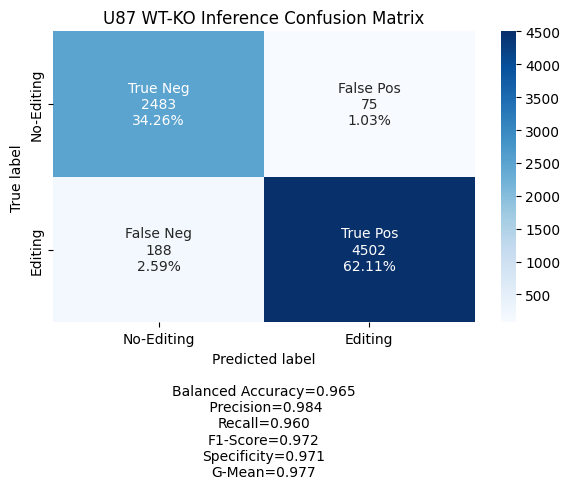

In [30]:
import os, sys, subprocess, shlex
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
from REDInet import Utils
from functools import reduce

def return_number(x):
    return x.replace("chr", "")


def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585", "outTable_208420383"],
                   ["outTable_572868058", "outTable_364841872", "outTable_814257267"],
                   ["outTable_110067244", "outTable_597789462", "outTable_530905096"]]

        rmsk_file = "rmsk_hg38.sorted.gtf.gz"

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]
        rmsk_file = "rmsk.sorted.gtf.gz"

    elif cell_line == "a549":
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
        rmsk_file = "rmsk.sorted.gtf.gz"
    else:
        samples = [["outTable_884892094", "outTable_431083763"]]
        rmsk_file = "rmsk.sorted.gtf.gz"
        
    utilities_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities"   
    files_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
    
    return samples, rmsk_file, utilities_path, files_path
                
def bona_fide_metrics_calculator(tables, tables_filespath, cells):
    if cells == "HEK293T":
        prefix = "HEK(hg38)"
        suffix_1 = "WT-KO"
        suffix_2 = "OVE-KO"
    elif cells == "a549":
        prefix = cells
        suffix_1 = "WT-SI"
    elif cells == "HEK":
        prefix = "HEK(hg19)"
        suffix_1 = "WT-KO"
    else:
        prefix = "U87"
        suffix_1 = "WT-KO"      
        
    y_true = []
    y_pred = []
    for i in range(len(tables)):
              
        sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                              sep="\t", usecols=["Region", "Position", "Class"])
              
        cols =  ["Region", "Position", "Strand", "Editing_Probability"]
        wt = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][0]}_predictions.txt"), sep="\t", usecols=cols)
        adars_inactive = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.txt"), sep="\t", usecols=cols)
        
        wt.loc[:, "index_wt"] = wt.index.tolist()
        adars_inactive.loc[:, "index_adars_inactive"] = adars_inactive.index.tolist()
        merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
        merged = merged.merge(sites, how="inner", on=["Region", "Position"])
        common_pos = merged[merged.loc[:, "Class"]==1]
        index_common_pos = common_pos.loc[:, "index_wt"].tolist()
        merged = merged[merged.loc[:, "Class"]==0]
        index_adars_inactive = merged.loc[:, "index_adars_inactive"].tolist()
        index_wt = merged.loc[:, "index_wt"].tolist()
        snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
        snps_wt = wt.iloc[index_wt, :]
        snps = pd.concat([snps_wt, snps_adars_inactive], axis=0)
        snps.drop(["index_wt", "index_adars_inactive"], axis=1, inplace=True)
        snps.reset_index(drop=True, inplace=True)
        index_drop = index_common_pos + index_wt
        index_drop.sort()
        pos = wt.drop(index_drop)
        pos.reset_index(drop=True, inplace=True)
        pos = pos.merge(sites, how="inner", on=["Region", "Position"])
        pos.reset_index(drop=True, inplace=True)
        
        y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
        y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()
        
        pos = pos.loc[:, ["Region", "Position", "Editing_Probability"]]
        pos.loc[:, "Class"] = 1
        snps = snps.loc[:, ["Region", "Position", "Editing_Probability"]]
        snps.loc[:, "Class"] = 0
        bonafide_extracted = pd.concat([pos, snps], axis=0)
        bonafide_extracted.sort_values(["Region", "Position"], inplace=True)
        bonafide_extracted.to_csv(os.path.join(tables_filespath, 
                                               f"{cells}_bonafide_final.tsv"), sep="\t", index=None)
        

    Utils().make_confusion_matrix(y_true,  y_pred,
                                  title = f"{prefix} {suffix_1} Inference Confusion Matrix",
                                  figsize=(6,5),
                                  path=os.path.join(tables_filespath, f"{cells}_{suffix_1}_Inference_Conf_Matrix.tiff"))
              
    if cells == "HEK293T":
              
        y_true = []
        y_pred = []
        for i in range(len(tables)):

            sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][2]}_{tables[i][1]}_bona_fide_sites.tsv"),
                                  sep="\t", usecols=["Region", "Position", "Class"])

            cols =  ["Region", "Position", "Strand", "Editing_Probability"]
            adars_overexpressed = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][2]}_predictions.tsv"), sep="\t", usecols=cols)
            ko = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)
            adars_overexpressed.loc[:, "index_adars_overexpressed"] = adars_overexpressed.index.tolist()
            ko.loc[:, "index_ko"] = ko.index.tolist()
            merged = adars_overexpressed.merge(ko, how ="inner", on=["Region", "Position", "Strand"])
            merged = merged.merge(sites, how="inner", on=["Region", "Position"])
            common_pos = merged[merged.loc[:, "Class"]==1]
            index_common_pos = common_pos.loc[:, "index_adars_overexpressed"].tolist()
            merged = merged[merged.loc[:, "Class"]==0]
            index_ko = merged.loc[:, "index_ko"].tolist()
            index_adars_overexpressed = merged.loc[:, "index_adars_overexpressed"].tolist()
            snps_ko = ko.iloc[index_ko, :]
            snps_adars_overexpressed = adars_overexpressed.iloc[index_adars_overexpressed, :]
            snps = pd.concat([snps_adars_overexpressed, snps_ko], axis=0)
            snps.drop(["index_adars_overexpressed", "index_ko"], axis=1, inplace=True)
            snps.reset_index(drop=True, inplace=True)
            index_drop = index_common_pos + index_adars_overexpressed
            index_drop.sort()
            pos = adars_overexpressed.drop(index_drop)
            pos.reset_index(drop=True, inplace=True)
            pos = pos.merge(sites, how="inner", on=["Region", "Position"])
            pos.reset_index(drop=True, inplace=True)

            y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
            y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()
                        
        Utils().make_confusion_matrix(y_true,  y_pred,
                              title = f"{prefix} {suffix_2} Inference Confusion Matrix",
                              figsize=(6,5),
                              path=os.path.join(tables_filespath, f"{cells}_{suffix_2}_Inference_Conf_Matrix_on.tiff"))
    
cells = "U87"

tables, rmsk, u_path, filespath =  give_inputs(cells) 
bona_fide_metrics_calculator(tables, filespath, cells)

In [31]:
rmsk = "rmsk.sorted.gtf.gz"
refseq = "hg19.ncbiRefSeq.sorted.gtf.gz"
u_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities" 
save_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"
file_name = "U87_bonafide_final.tsv"

df = pd.read_csv(os.path.join(save_path, file_name), sep="\t")
df.to_csv(os.path.join(save_path, file_name), sep="\t", index=None, header=False)
name = file_name.replace(".tsv", "")
cmd_sh = "python3 {}/AnnotateTablePython3.py -a {}/{} -n rmsk -i {}/{}.tsv -o {}/{}.out.rmsk -u".format(u_path, u_path, rmsk, save_path, name, save_path, name)
args = shlex.split(cmd_sh)
p = subprocess.Popen(args, env=dict(os.environ, PATH="/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/bin"))

time.sleep(120)

cols = ["Region", "Position", "REDInet_Probability", "Class", "RMSK-Rep", 
        "RMSK-Reg"]

df = pd.read_table(os.path.join(save_path, file_name.replace(".tsv", ".out.rmsk")), header=None)
df.columns = cols
df.loc[:, ["Region", "Position", "REDInet_Probability", "Class"]].to_csv(os.path.join(save_path, file_name), sep="\t", index=None)
alu = df[df.loc[:, "RMSK-Reg"].str.find("Alu")!=-1].loc[:, ["Region", "Position"]]
non_alu = df[df.loc[:, "RMSK-Reg"].str.find("Alu")==-1].loc[:, ["Region", "Position"]]
alu.loc[:, "Region"] = alu.loc[:, "Region"].apply(return_number)
non_alu.loc[:, "Region"] = non_alu.loc[:, "Region"].apply(return_number)
alu.to_csv(os.path.join(save_path, "U87_bona_fide_final_alu.txt"), sep="\t", index=None, header=False)
non_alu.to_csv(os.path.join(save_path, "U87_bona_fide_final_non_alu.txt"), sep="\t", index=None, header=False)

Pysam version used: 0.15.4
Script time --> START: 20/07/2024 21:06:43
Table saved on /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87/U87_bonafide_final.out.rmsk
Script time --> END: 20/07/2024 21:07:01


In [52]:
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm

def return_region(x):
    return "chr{}".format(x)

save_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/U87"

bonafide = pd.read_table(os.path.join(save_path, "U87_bonafide_final.tsv"))
bonafide.loc[:, "Position"] = bonafide.loc[:, "Position"].astype("int32")

cols = ["Chromosome", "Position", "YES_prob"]

edi = pd.DataFrame()

edi = pd.concat([edi, pd.read_table(os.path.join(save_path, "U87_EditPredict_Alu.txt"), usecols=cols)], axis=0)
edi = pd.concat([edi, pd.read_table(os.path.join(save_path, "U87_EditPredict_Non_Alu.txt"), usecols=cols)], axis=0)

edi.columns = ["Region", "Position", "EditPredict_Probability"]
edi.loc[:, "Region"] = edi.loc[:, "Region"].apply(return_region)
edi.dropna(axis=0, inplace=True)
edi.loc[:, "Position"] = edi.loc[:, "Position"].astype("int32")

merged = edi.merge(bonafide, how="inner", on=["Region", "Position"])
merged.drop_duplicates(keep="first", inplace=True)

print(merged)

6391
     Region  Position  EditPredict_Probability  REDInet_Probability  Class
0      chr1   1594999             5.315101e-01         1.000000e+00      1
1      chr1   1595006             6.645999e-04         1.000000e+00      1
2      chr1   1595007             4.656336e-01         1.000000e+00      1
3      chr1   1595021             5.571829e-01         1.000000e+00      1
4      chr1   1595025             7.963933e-01         1.000000e+00      1
...     ...       ...                      ...                  ...    ...
8614   chrX  47045733             1.446935e-11         1.000000e+00      1
8615   chrX  47082976             7.788525e-13         1.000000e+00      1
8616   chrX  47444985             3.589001e-15         3.977076e-22      0
8617   chrX  47444985             3.589001e-15         2.766520e-14      0
8620   chrX  48759302             3.826279e-10         1.000000e+00      1

[6384 rows x 5 columns]


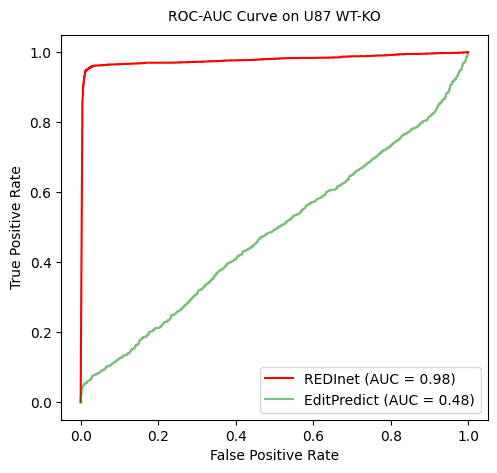

In [56]:
redi_true = edi_true = merged.loc[:, "Class"].tolist()
redi_pred = merged.loc[:, "REDInet_Probability"].tolist()
edi_pred = merged.loc[:, "EditPredict_Probability"].tolist()

fig, ax = plt.subplots(figsize=(5.5, 5))
fpr_redi, tpr_redi, thresholds_redi = metrics.roc_curve(redi_true, redi_pred)
AUC_redi = metrics.auc(fpr_redi, tpr_redi,)
ROC = metrics.RocCurveDisplay(fpr=fpr_redi, tpr=tpr_redi, roc_auc=AUC_redi).plot(ax=ax, color="red", name="REDInet")
fpr_edi, tpr_edi, thresholds_edi = metrics.roc_curve(edi_true, edi_pred)
AUC_edi = metrics.auc(fpr_edi, tpr_edi)
ROC_edi = metrics.RocCurveDisplay(fpr=fpr_edi, tpr=tpr_edi, roc_auc=AUC_edi).plot(ax=ax, color="green", name="EditPredict", alpha=0.5) 

ax.set_title(f"ROC-AUC Curve on U87 WT-KO", fontsize=10, pad=10)
plt.savefig(f"{save_path}/ROC-AUC_on_U87_WT_KO.tiff", dpi=600, facecolor='white', transparent=False) 
plt.show()